<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# kaiser window is adjustable
# we can optimmise the beta parameter to balance between sensitivity, main lobe width and contrast


In [2]:
# run this on top of all of Your notebooks -- it does all the dirty imports.
exec(open('initialize_jupyter_handybeam.py').read())
import strathclyde

In [49]:
# make a shortcut function that runs the entire HandyBeam process and returns nicely formatted outputs

def array_using_kaiser(beta=1):
    focal_point=(0.0,30e-3,40e-3)
    focal_radius=np.sqrt(focal_point[0]**2+focal_point[1]**2+focal_point[2]**2)
    # array builder
    array_builder=strathclyde.LinearArray(
        radiation_frequency=500e3,
        sound_velocity=5600,
        sampling_density=11,
        passive_aperture=32e-3,
        element_pitch=3e-3,
        element_width=1e-3,
        element_count=16,
        focal_point=focal_point,
        amplitude_setting=1e4,
        window_coefficients=scipy.signal.windows.kaiser(16,beta=beta))
    # handybeam
    handybeam_world = array_builder.create_handybeam_world()
    
    # create a sampling line, semi-circle around the array, to sample the field there
    tau=2*np.pi
    sampler_radius=focal_radius
    sampler_angles=np.linspace(-tau/4,tau/4,num=4*2048,endpoint=True)
    ys=np.sin(sampler_angles)*sampler_radius
    zs=np.cos(sampler_angles)*sampler_radius
    xs=np.zeros(ys.shape)

    semicircle_sampler=handybeam_world.add_sampler(handybeam.samplers.clist_sampler.ClistSampler())
    semicircle_sampler.add_sampling_points(xs,ys,zs)
    semicircle_sampler.propagate(print_performance_feedback=False)
    # analiser
    stats=strathclyde.analyse_semicircle_sampled_data(sampler_angles,sampler_radius,semicircle_sampler.pressure_field)
    return array_builder,handybeam_world,semicircle_sampler,sampler_angles,stats

Main lobe:
 >> peak amplitude value: 1.007438063621521
 >> peak location : 0.646 radians = 37.04 degrees
 >> angular width (-3dB): 0.248 radians = 14.20 degrees
 >> linear width (-3dB): {:0.3f} 
integrated main lobe power: 535.3888549804688
Side lobes:
 >> peak side lobe value :0.2665857970714569
 >> integrated side lobe power: 80.09767150878906
Contrast metric:
 >> integrated main lobe to side lobe ratio: 16.50 dB


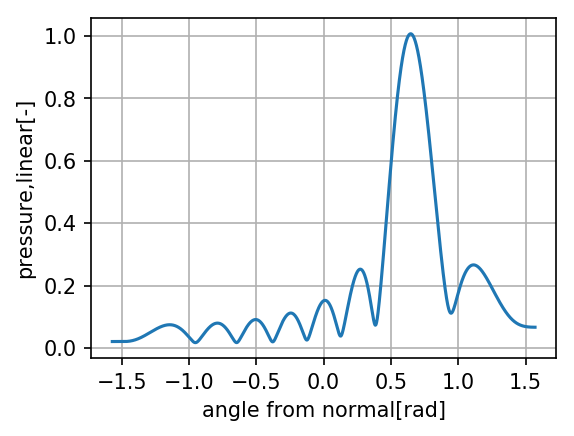

In [50]:
ab,hw,sc,sampler_angles,stats = array_using_kaiser(0.01)
strathclyde.print_analysis(stats)
handybeam.visualise.plot_1D_pressure_vs_angle(hw,sampler_angles,np.abs(sc.pressure_field))

In [51]:
stats

{'pabs': array([0.02092377, 0.02092354, 0.0209238 , ..., 0.06674577, 0.06674573,
        0.06674531], dtype=float32),
 'peak_p': 1.0074381,
 'peak_location_idx': 5781,
 'peak_location_angle': 0.646460068077841,
 'p_db': array([-33.65157 , -33.651665, -33.651558, ..., -23.575893, -23.5759  ,
        -23.57595 ], dtype=float32),
 'db_mask_3db': array([False, False, False, ..., False, False, False]),
 'beam_width_idx': 647,
 'first_up': 5468,
 'last_up': 6114,
 'beam_width_3db_radians': 0.24776814237809885,
 'beam_width_linear': 0.012388407118904944,
 'mask_main_lobe_right': 6761,
 'mask_main_lobe_left': 4821,
 'mask_main_lobe': array([False, False, False, ..., False, False, False]),
 'power_main_lobe': 535.38885,
 'power_side_lobes': 80.09767,
 'peak_sidelobe': 0.2665858,
 'contrast_mts_ratio': 16.500988006591797}

In [52]:
# run a parameter sweep: try beta in range of 0.1 to 10

kaiser_betas=np.linspace(0.1,5,30)
# reserve buffers for interesting outputs, discard the rest
power_main_lobes=np.full(kaiser_betas.shape,np.nan)
contrast_mts_ratios=np.full(kaiser_betas.shape,np.nan)
beam_width_linears=np.full(kaiser_betas.shape,np.nan)

# run the calculations for all betas of interest
for idx,beta in enumerate(kaiser_betas):
    ab,hw,sc,sampler_angles,stats = array_using_kaiser(beta)
    power_main_lobes[idx]=stats.power_main_lobe
    contrast_mts_ratios[idx]=stats.contrast_mts_ratio
    beam_width_linears[idx]=stats.beam_width_linear
    
    

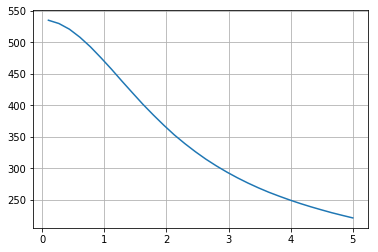

In [53]:
# plot the sensitivity (power_main_lobes)
plt.plot(kaiser_betas,power_main_lobes)
plt.grid(True)

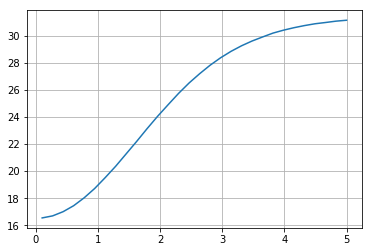

In [54]:
# plot the contrast measure
plt.plot(kaiser_betas,contrast_mts_ratios)
plt.grid(True)

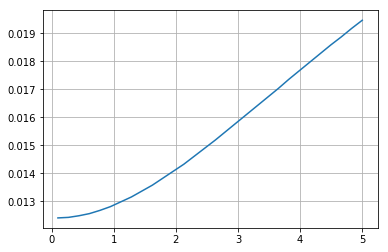

In [55]:
# plot the resolution measure
plt.plot(kaiser_betas,beam_width_linears)
plt.grid(True)

In [56]:
# check performance - how many evaluations can You afford?
%timeit ab,hw,sc,sampler_angles,stats = array_using_kaiser(0.01)

105 ms ± 5.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Text(0.5,0,'sampler_angles[rad]')

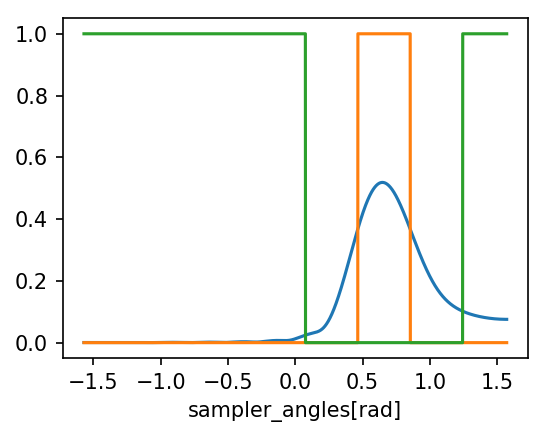

In [58]:
plt.figure(figsize=(4,3),dpi=150)
plt.plot(sampler_angles,np.abs(sc.pressure_field),sampler_angles,stats['db_mask_3db'],sampler_angles,~stats['mask_main_lobe'])
plt.xlabel('sampler_angles[rad]')